In [1]:
"""Combined Benchmark File

This script is used to benchmark overall performance of the system.
"""

import numpy as np
import cv2
from functools import partial
from chrono import Timer
import time
import math
from copy import deepcopy

import scipy.spatial

from acquisition import VideoStream
from utility_functions import crosshair
from YOLO_detector_wrapper import setup, detect_wrapper
from centroid_tracker import Centroid_Tracker

from utility_functions import crosshair, heron, regularity
from itertools import combinations, compress

# Benchmark settings
early_terminate = False #200
repeat_attempts = 5 #3

# Environment Support Geometry
raw_pts = np.asarray([[0,212], [260,487], [404, 486], [400, 327], [410, 328], [959, 147], [959, 538], [0, 537], [0,212]])
contour = np.array(raw_pts[:-1]).reshape((-1,1,2)).astype(np.int32)

# Define subdivision size for void detection
subdiv_distance = 30

# Define criteria for good / ok / bad packing => Void detection
area_ok = 524
area_ok_reg = 519
reg_ok = 0.08
area_bad = 643
area_bad_reg = 563
reg_bad = 0.04

# Define criteria for collision propagation
collision_dist = 50   

# Define video stream
SCALE_FACTOR = 0.5
vs = VideoStream(src = "../Data_Generator/Assets/Outputs/2021-03-18_20h40m_Camera1_011.webm", 
                    fps = 30, height = int(1080*SCALE_FACTOR), width = int(1920*SCALE_FACTOR))

# Define detector
model = setup()
detector_func = partial(detect_wrapper, model=model, debug=False)

#_tracker = CentroidTracker(max_lost=3, tracker_output_format='mot_challenge')
_tracker = Centroid_Tracker(max_lost=3)

# Start the video stream object
vs.start()

# Create empty (nested) lists for storing the data per run
acquisition_times = []
detection_times = []
tracker_times = []
damage_times = []
void_times = []
total_times = []
tracker = []

for i in range(repeat_attempts):
    acquisition_times.append([])
    detection_times.append([])
    tracker_times.append([])
    damage_times.append([])
    void_times.append([])
    total_times.append([])

    # Create deep copies of the tracker to be used (so restart from 0)
    tracker.append(deepcopy(_tracker))


for attempt_no in range(repeat_attempts):

    # Restart video stream properties each attempt
    vs.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_no = 0
    objectID = 1

    # Main logic loop
    while True:

        # Provide overall timer for full frame processing 
        with Timer() as full_timed:

            # Time the acquisition step
            with Timer() as acquisition_timed:
                ret, frame = next(vs.read())
                if not ret:
                    break

            # Time the detection
            with Timer() as detector_timed:
                ret, bboxes, points = detector_func(frame)

            # Time tracker update
            with Timer() as tracker_timed:
                objectID, trackedObjects = tracker[attempt_no].update(objectID, points)

            



            with Timer() as damage_timed:

                population_metrics = {"time":[], "velocity":[], "damage":[]}

                # Iterate through tracked objects and annotate
                for idx, object in zip(trackedObjects.keys(), trackedObjects.values()):

                    # Read position deque for tracked object and calculate framewise differences for velocity
                    if len(object["positions"]) > 5:
                        
                        k_scale = 0.01 # Calibration parameter for scaling between image and real world dimensions                
                        dt = 1 / 30 # Time increment per frame

                        # Find frame-wise motion properties
                        positions = np.asarray(object["positions"]) * k_scale
                        velocities = np.diff(positions, axis=0) / dt
                        mean_speed = np.linalg.norm(np.mean(velocities, axis=0))

                        accelerations = np.diff(velocities, axis=0) / dt
                        mean_acceleration = np.mean(accelerations, axis=0)
                        acceleration_norm = np.linalg.norm(mean_acceleration)

                        # High speed (greater changer momentum) collisions contribute to more damage (E=0.5mv^2) => quadratic relation
                        # Impacts can cause failure through crack propagation if energetic enough
                        # Otherwise cause microcrack formation (which shall be ignored - simplifying assumption)
                        damage_speed = 0
                        if acceleration_norm > 10:

                            # Increment a damage quantity proportional to squared impact velocity if acceleration norm large enough
                            k_speed = 0.01
                            impact_speed = np.linalg.norm(np.mean(velocities[-4:-1], axis=0))
                            damage_speed = k_speed * impact_speed * impact_speed
                            # Note - coefficient should take into account ability to double up application, or only exert once in collision with wall

                            # Visualise instant collisions (yellow)
                            crosshair(frame, object["positions"][-1], size = 8, color = (0,255,255))

                            # Damage sharing
                            # Extract position of this object and all others (separately)
                            this_pos = object["positions"][-1]
                            other_pos = [trackedObjects[k]["positions"][-1] for k in trackedObjects.keys() if k != idx]

                            # Find the euclidean distance between current point and all others
                            positions_rep = np.tile(this_pos, (len(other_pos),1))
                            norm_diff = np.linalg.norm(other_pos - positions_rep, axis=1)

                            # If close, extract tracker id (key) for incrementing damage
                            collided_instances = norm_diff <= collision_dist
                            indices = list(compress(range(len(collided_instances)), collided_instances))
                            collision_keys = [list(trackedObjects.keys())[_t] for _t in indices]
                            
                            # Add damage equal to collision intensity
                            for collision_key in collision_keys:
                                trackedObjects[collision_key]["damage"] += damage_speed


                        # More time in the system increases likeliness of repeated / cumulative loading - incremental
                        k_time = 1
                        damage_time = k_time * dt

                        # Combine damage metrics
                        damage_delta = damage_speed + damage_time
                        object["damage"] += damage_delta

                        # Visualise damaged candidates (red)
                        if object["damage"] > 10:
                            crosshair(frame, object["positions"][-1], size = 8, color = (0,0,255))

                        population_metrics["time"].append(object["time"])
                        population_metrics["velocity"].append(mean_speed)
                        population_metrics["damage"].append(object["damage"])

            #print("Damage process time (ms):", damage_timed.elapsed)

            # Log and print population metrics
            """
            times.append(population_metrics["time"])
            speeds.append(population_metrics["velocity"])
            damages.append(population_metrics["damage"])

            print(f'Population residence time: Mean = {np.mean(population_metrics["time"])}, SD = {np.std(population_metrics["time"])}')
            print(f'Population velocity: Mean = {np.mean(population_metrics["velocity"])}, SD = {np.std(population_metrics["velocity"])}')
            print(f'Population damage: Mean = {np.mean(population_metrics["damage"])}, SD = {np.std(population_metrics["damage"])}')
            """


            # VOIDS (SPATIAL DESCRIPTOR)
            # Create canvas for image-based void counting
            blank_canvas = np.zeros(frame.shape)
            with Timer() as void_timed:
                
                # Check if enough (3) points for triangulation
                if len(points) > 3:

                    allPt = []

                    # Make copy of support contour points
                    refPt = deepcopy(raw_pts)

                    # Transform to numpy arrays, and create shifted version for distance calcs
                    point1 = np.asarray(refPt)
                    point2 = np.roll(point1, -1, axis = 0)

                    # Iterate over and add points to list (including subdivisions if required)
                    for j in range(len(point1)-1):
                        
                        # Take two adjacent points and calculate the distance between these
                        p1 = point1[j]
                        p2 = point2[j]
                        _p1 = list(map(int, p1))
                        allPt.append(_p1)
                        dist = np.linalg.norm(p2 - p1)
                        
                        # Perform subdivision of line segment if too large
                        if dist > subdiv_distance:

                            # Find direction vector
                            dir_vector = np.subtract(p2, p1)

                            # Find number of samples (round up to enforce maximum size)
                            sample_no = math.ceil(dist / subdiv_distance)
                            
                            # Calculate subdivision (fragment) distance
                            fragd = subdiv_distance / dist

                            # Iterate through and generate extra points
                            for i in range(sample_no):
                                vecPt = p1 + np.multiply(fragd * i, dir_vector)
                                _vecPt = list(map(int, vecPt))
                                allPt.append(_vecPt)

                        # Otherwise add (int) end point to list
                        else:
                            _p2 = list(map(int, p2))
                            allPt.append(_p2)

                    
                    # Extend original point array with support points
                    points.extend(allPt)

                    # Calculate delaunay triangulation
                    ts = scipy.spatial.Delaunay(points)

                    # Select triangles
                    points = np.asarray(points)
                    pts_shaped = points[ts.simplices]

                    # Find centre points
                    px = np.asarray([(ptt[0][0] + ptt[1][0] + ptt[2][0]) / 3 for ptt in pts_shaped], dtype="int").reshape(-1,1)
                    py = np.asarray([(ptt[0][1] + ptt[1][1] + ptt[2][1]) / 3 for ptt in pts_shaped], dtype="int").reshape(-1,1)
                    pts = np.concatenate((px,py),axis = 1)

                    # Test if centre points in valid region => only keep valid triangle points
                    in_contour = [cv2.pointPolygonTest(contour, tuple(pttt), False) for pttt in pts]
                    pts = pts[np.asarray(in_contour) < 0]
                    pts_shaped = pts_shaped[np.asarray(in_contour) < 0]

                    # Combine heron (area) and regularity functions, and map to point list
                    comb_funcs = lambda x: (heron(x[0], x[1], x[2]), regularity(x[0], x[1], x[2]))
                    comb_outputs = list(map(comb_funcs, pts_shaped))
                    ar, reg = map(list, zip(*comb_outputs))

                    # Colorise good packing as green (colour all using convex hull)
                    conv = points[scipy.spatial.ConvexHull(points).vertices]
                    cv2.fillPoly(blank_canvas, [conv], (0,255,0))

                    # Overlay / mask invalid region
                    cv2.drawContours(blank_canvas,[contour],0,(0,0,0),-1)

                    # Filter other severities of packing using logical numpy operator
                    warn_pts = pts_shaped[ np.logical_or((np.asarray(ar)>area_ok), np.logical_and((np.asarray(ar)>area_ok_reg), (np.asarray(reg) > reg_ok))) ]
                    crit_pts = pts_shaped[ np.logical_or((np.asarray(ar)>area_bad), np.logical_and((np.asarray(ar)>area_bad_reg), (np.asarray(reg) > reg_bad))) ]

                    # Colorise other regions
                    cv2.fillPoly(blank_canvas, warn_pts, (255,0,0))
                    cv2.fillPoly(blank_canvas, crit_pts, (0,0,255))

                    # Combine adjacent regions and count
                    good_canvas = cv2.inRange(blank_canvas, (0,10,0), (0,255,0))
                    good_canvas = cv2.erode(good_canvas, (5,5))
                    _good_count, _labels = cv2.connectedComponents(good_canvas)
                    good_count = _good_count - 1
                        
                    crit_canvas = cv2.inRange(blank_canvas, (0,0,10), (0,0,255))
                    crit_canvas = cv2.erode(crit_canvas, (5,5))
                    _crit_count, _labels = cv2.connectedComponents(crit_canvas)
                    crit_count = _crit_count - 1
                        
                    warn_canvas = cv2.inRange(blank_canvas, (10,0,0), (255,0,0))
                    warn_canvas = cv2.erode(warn_canvas, (5,5))
                    _warn_count, _labels = cv2.connectedComponents(warn_canvas)
                    warn_count = _warn_count - 1

                    # Visualise this as a 50% opacity overlap
                    frame = cv2.addWeighted(frame, 0.5, blank_canvas.astype("uint8"), 0.5, 1)

                    """
                    print(f"INFO: There are {good_count} good regions")
                    print(f"INFO: There are {warn_count} warning regions")
                    print(f"INFO: There are {crit_count} critical regions")
                    """

            """
            # Iterate through tracked objects and annotate
            for idx, object in zip(trackedObjects.keys(), trackedObjects.values()):
                crosshair(frame, object["positions"][-1], size = 8, color = (0,0,255))

            # Show annotated frame
            cv2.imshow("Frame", frame)
            
            # Only wait for 1ms to limit the performance overhead
            key = cv2.waitKey(1) & 0xFF

            # Escape / close if "q" pressed
            if key == ord("q"):
                break
            """
            
        # Print elapsed time
        print("Total time elapsed (ms): ", full_timed.elapsed*1000)

        # Append attempt data to list
        acquisition_times[attempt_no].append(acquisition_timed.elapsed)
        detection_times[attempt_no].append(detector_timed.elapsed)
        tracker_times[attempt_no].append(tracker_timed.elapsed)
        damage_times[attempt_no].append(damage_timed.elapsed)
        void_times[attempt_no].append(void_timed.elapsed)
        total_times[attempt_no].append(full_timed.elapsed)

        
        # Break from loop early - for testing
        if bool(early_terminate):
            if frame_no > early_terminate:
                break
        
        frame_no += 1

# Assign mean values to lists
acquisition_times_avg = np.mean(np.asarray(acquisition_times) * 1000, axis=0).tolist()
detection_times_avg = np.mean(np.asarray(detection_times) * 1000, axis=0).tolist()
tracker_times_avg = np.mean(np.asarray(tracker_times) * 1000, axis=0).tolist()

damage_times_avg = np.mean(np.asarray(damage_times) * 1000, axis=0).tolist()
void_times_avg = np.mean(np.asarray(void_times) * 1000, axis=0).tolist()

total_times_avg = np.mean(np.asarray(total_times) * 1000, axis=0).tolist()

# Show plots
#plt.show()

# Tidy up - close windows and stop video stream object
cv2.destroyAllWindows()
vs.stop()

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Fusing layers... Model Summary: 235 layers, 5.24706e+07 parameters, 5.04494e+07 gradients
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  39.000511169433594
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.715734481811523
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.417804718017578
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  28.283357620239258
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.226665496826172
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.930549621582

Total time elapsed (ms):  48.749446868896484
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  47.5308895111084
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  48.67100715637207
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  49.10707473754883
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  49.759626388549805
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  51.62334442138672
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  50.592899322509766
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  53.04694175720215
Us

Total time elapsed (ms):  75.6387710571289
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.54643058776855
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  75.63352584838867
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.04830169677734
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.45797729492188
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.34918594360352
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  79.16808128356934
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.08024978637695
Using

Total time elapsed (ms):  91.11380577087402
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.58866310119629
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  93.1394100189209
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  95.50094604492188
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  93.93167495727539
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  94.07687187194824
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  94.68698501586914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  95.3972339630127
Using 

Total time elapsed (ms):  111.3591194152832
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.98995399475098
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  113.5709285736084
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.57376861572266
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  112.3342514038086
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  109.41171646118164
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.94880104064941
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  113.3260726928711


Total time elapsed (ms):  127.97927856445312
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  125.76055526733398
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  128.39150428771973
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  126.82986259460449
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  126.68704986572266
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  127.05516815185547
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  126.96266174316406
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  127.84528732299

Total time elapsed (ms):  141.07656478881836
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  141.2220001220703
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  141.77536964416504
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.56308364868164
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  140.54107666015625
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  140.2273178100586
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  142.76123046875
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.0233039855957
Us

Total time elapsed (ms):  27.385950088500977
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.166107177734375
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.566484451293945
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.82493019104004
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.708581924438477
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.618221282958984
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.745059967041016
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.6963500976562

Total time elapsed (ms):  65.79470634460449
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  64.72134590148926
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  65.31095504760742
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  64.47005271911621
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  66.94293022155762
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  63.52090835571289
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  62.430381774902344
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  63.666582107543945
Us

Total time elapsed (ms):  78.01556587219238
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.47244834899902
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.95381546020508
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.51011848449707
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.15868949890137
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.06785202026367
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.96955108642578
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.88474655151367
Usin

Total time elapsed (ms):  92.2994613647461
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.2400951385498
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  91.400146484375
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.54145622253418
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.35572814941406
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.14282035827637
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  93.10007095336914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  91.65668487548828
Using CU

Total time elapsed (ms):  110.63718795776367
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.6882095336914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.1076602935791
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  109.70401763916016
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  111.07897758483887
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  109.01713371276855
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.76235771179199
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.1529598236084

Total time elapsed (ms):  125.65827369689941
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  122.78223037719727
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  123.59738349914551
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  124.32408332824707
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  123.96955490112305
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  128.0992031097412
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  123.83794784545898
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  123.065471649169

Total time elapsed (ms):  142.5919532775879
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  147.5696563720703
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  141.9990062713623
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.44673538208008
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  140.8698558807373
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  140.31386375427246
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.54973220825195
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  29.90269660949707
U

Total time elapsed (ms):  49.79825019836426
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  47.756195068359375
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  48.00081253051758
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  48.28166961669922
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  49.12686347961426
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  51.63311958312988
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  49.723148345947266
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  50.110578536987305
U

Total time elapsed (ms):  72.51763343811035
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  71.79880142211914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  73.98772239685059
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  74.64456558227539
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  75.97947120666504
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.09391212463379
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.60460472106934
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.03161239624023
Usin

Total time elapsed (ms):  90.1186466217041
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  89.76316452026367
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  91.99357032775879
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.60797500610352
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  94.65765953063965
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.99564361572266
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  96.15683555603027
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  93.9340591430664
Using 

Total time elapsed (ms):  107.09714889526367
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  105.11445999145508
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  106.68587684631348
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.45184326171875
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  110.49127578735352
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  111.88721656799316
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  111.31405830383301
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.45851898193

Total time elapsed (ms):  128.71837615966797
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  125.5044937133789
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  127.11334228515625
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  125.27894973754883
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  131.38628005981445
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  125.92101097106934
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  130.9792995452881
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  123.6746311187744

Total time elapsed (ms):  140.1958465576172
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  136.88158988952637
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.19663429260254
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  139.95862007141113
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  148.55599403381348
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  156.0354232788086
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  149.89233016967773
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  148.7128734588623

Total time elapsed (ms):  25.509119033813477
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.667428970336914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.35612678527832
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.51436424255371
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.21712875366211
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.61695671081543
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.509906768798828
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.866580963134766


Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  67.53134727478027
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  67.70205497741699
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  70.13893127441406
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  67.49653816223145
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  65.08588790893555
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  69.08059120178223
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  66.32709503173828
Using CUDA device0 _CudaDeviceProperties(name='G

Total time elapsed (ms):  78.23824882507324
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  78.56202125549316
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  78.50861549377441
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  78.02867889404297
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.35681533813477
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  76.66778564453125
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  80.0931453704834
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  77.06236839294434
Using

Total time elapsed (ms):  94.07806396484375
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  91.86935424804688
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  94.04969215393066
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  93.3682918548584
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  91.73774719238281
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.38290786743164
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  94.12193298339844
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  92.28372573852539
Using

Total time elapsed (ms):  108.87908935546875
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  107.85126686096191
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  114.0284538269043
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.2613468170166
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  109.14325714111328
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.25872421264648
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  112.79964447021484
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  108.8757514953613

Total time elapsed (ms):  128.24583053588867
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  127.78878211975098
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  132.3087215423584
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  124.71151351928711
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  132.4906349182129
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  129.42743301391602
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  135.66040992736816
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  132.0059299468994

Total time elapsed (ms):  137.709379196167
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  137.46380805969238
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  137.78114318847656
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  137.0084285736084
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  138.17882537841797
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  137.0682716369629
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  138.6392116546631
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  137.56275177001953
U

Total time elapsed (ms):  24.39093589782715
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.830175399780273
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.080514907836914
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  24.07526969909668
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  23.837804794311523
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.335073471069336
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.29144287109375
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  25.38919448852539


Total time elapsed (ms):  63.231468200683594
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  62.49642372131348
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  63.269615173339844
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  65.10424613952637
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  64.83078002929688
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  64.67866897583008
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  65.26541709899902
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  65.44899940490723
Us

Total time elapsed (ms):  78.93586158752441
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  78.43208312988281
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  79.87022399902344
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  79.66208457946777
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  79.36215400695801
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  79.5598030090332
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  81.9554328918457
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  81.69031143188477
Using 

Total time elapsed (ms):  97.46146202087402
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  95.72124481201172
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  98.59585762023926
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  97.25594520568848
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  99.36237335205078
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  100.24785995483398
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  101.66335105895996
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  101.17483139038086
U

Total time elapsed (ms):  155.43389320373535
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  119.0798282623291
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  112.62130737304688
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  113.82603645324707
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  115.36145210266113
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  115.27395248413086
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  116.57953262329102
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  117.217779159545

Total time elapsed (ms):  134.14621353149414
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  133.13865661621094
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  129.70447540283203
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  129.32205200195312
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  134.3376636505127
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  131.4699649810791
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  133.69393348693848
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Total time elapsed (ms):  133.8305473327636

In [9]:
import pandas as pd
#labels = ["Acquisition", "Detection", "Tracking", "Damage", "Voids"]
labels = ["Acquisition", "Detection", "Tracking", "Damage", "Toppling"]
np_arrays = np.asarray(list(map(np.asarray, [acquisition_times_avg, detection_times_avg, tracker_times_avg, damage_times_avg, void_times_avg])))
df = pd.DataFrame(np_arrays.T, columns=labels)
df.head()
df.to_csv("Combined_Benchmark_Data.csv", index=False)

In [ ]:
"""# Graph the frame time contribution
import matplotlib.pyplot as plt

# For pgf output for Latex
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.rcParams.update({'font.size': 13})

fig,ax = plt.subplots()
ax.set_ylabel("Frame Time (ms)")
ax.set_xlabel("Frame Number")

ax.set_ylim(0,100)
ax.set_xlim(0,len(total_times_avg)-2)

# Generate array for x data
t = np.arange(0, len(total_times_avg))


labels = ["Acquisition", "Detection", "Tracking", "Damage", "Voids"]

# Show a stacked plot for the other variables on top
ax.stackplot(t, acquisition_times_avg, detection_times_avg, tracker_times_avg, damage_times_avg, void_times_avg,
            alpha=1.0, labels=labels)

# Display the legend - consider placing top left for extended run?
ax.legend(loc="upper left")

# Show the 30FPS line (realtime threshold)
import matplotlib.transforms as transforms
ax.axhline(y=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(3, 33.3 + 
            ax.get_ylim()[1] * 0.01 + 1.5), xycoords="data", color="black")

# Enforce integer ticks on x-axis for discrete / integer frame numbers
import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()

plt.savefig('Combined_Benchmark.pgf')"""

In [10]:
df_in = pd.read_csv("Combined_Benchmark_Data.csv")
df_in.head()

,Acquisition,Detection,Tracking,Damage,Voids
0,9.957743,21.645546,0.022459,0.033712,0.005722
1,3.401279,20.261812,0.018883,0.004339,0.005102
2,2.808046,20.763016,0.019455,0.004482,0.006580
3,2.923679,20.511341,0.019455,0.004148,0.005817
4,3.059864,20.477200,0.019169,0.004435,0.005150


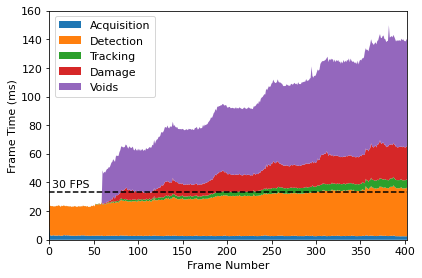

In [13]:
"""import matplotlib.pyplot as plt

# For pgf output for Latex
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.rcParams.update({'font.size': 13})"""

import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.set_ylabel("Frame Time (ms)")
ax.set_xlabel("Frame Number")

#ax.set_ylim(0,100)
ax.set_ylim(0,160)
ax.set_xlim(0,len(df_in)-2)

# Generate array for x data
t = np.arange(0, len(df_in))


#labels = ["Acquisition", "Detection", "Tracking", "Damage", "Voids"]
#labels = ["Acquisition", "Detection", "Tracking", "Damage", "Toppling"]

# Show a stacked plot for the other variables on top
#ax.stackplot(t, acquisition_times_avg, detection_times_avg, tracker_times_avg, damage_times_avg, void_times_avg,
#            alpha=1.0, labels=labels)

labels = df_in.columns.values
ax.stackplot(t, [df_in[label] for label in labels],
            alpha=1.0, labels=labels)
             

# Display the legend - consider placing top left for extended run?
ax.legend(loc="upper left")

# Show the 30FPS line (realtime threshold)
import matplotlib.transforms as transforms
ax.axhline(y=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(3, 33.3 + 
            ax.get_ylim()[1] * 0.01 + 1.5), xycoords="data", color="black")

# Enforce integer ticks on x-axis for discrete / integer frame numbers
import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()
#plt.savefig('Combined_Benchmark.pgf')

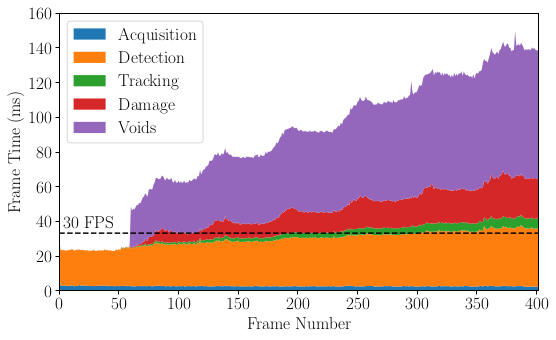

In [25]:
import matplotlib.pyplot as plt

# For pgf output for Latex
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.set_ylabel("Frame Time (ms)")
ax.set_xlabel("Frame Number")

#ax.set_ylim(0,100)
ax.set_ylim(0,160)
ax.set_xlim(0,len(df_in)-2)

# Generate array for x data
t = np.arange(0, len(df_in))


#labels = ["Acquisition", "Detection", "Tracking", "Damage", "Voids"]
#labels = ["Acquisition", "Detection", "Tracking", "Damage", "Toppling"]

# Show a stacked plot for the other variables on top
#ax.stackplot(t, acquisition_times_avg, detection_times_avg, tracker_times_avg, damage_times_avg, void_times_avg,
#            alpha=1.0, labels=labels)

labels = df_in.columns.values
ax.stackplot(t, [df_in[label] for label in labels],
            alpha=1.0, labels=labels)
             

# Display the legend - consider placing top left for extended run?
ax.legend(loc="upper left")

# Show the 30FPS line (realtime threshold)
import matplotlib.transforms as transforms
ax.axhline(y=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(3, 33.3 + 
            ax.get_ylim()[1] * 0.01 + 1.5), xycoords="data", color="black")

# Enforce integer ticks on x-axis for discrete / integer frame numbers
import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
#plt.show()
plt.savefig('Combined_Benchmark.pgf')